# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

We import required packages for our project.
We call in our model that we have set up in the py-file.
Moreover, we setup autoreload.

In [1]:
# Importing all required packages for our project
from types import SimpleNamespace

import numpy as np
from scipy import optimize
from scipy.optimize import minimize

import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# Setting up our model, the class

class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production 
        #H = HM**(1-par.alpha)*HF**par.alpha
        H = None
        if (par.sigma == 1):
            H = HM**(1-par.alpha)*HF**par.alpha
        elif (par.sigma == 0):
            H = min(HM,HF)
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

        
    def solve_continuous(self, do_print=False):
        """solve the model using continuous optimization"""
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        # Define the objective function to be minimized
        def objective(x):
            LM, HM, LF, HF = x
            return -self.calc_utility(LM, HM, LF, HF)
        
        # Define the constraint functions
        def constraint1(x):
            LM, HM, LF, HF = x
            return 24 - (LM + HM)
        
        def constraint2(x):
            LM, HM, LF, HF = x
            return 24 - (LF + HF)
        
        # Define the initial guess for the decision variables
        x0 = [6, 6, 6, 6]
        
        # Define the bounds for the decision variables
        bounds = ((0, 24), (0, 24), (0, 24), (0, 24))
        
        # Define the constraints
        cons = [{'type': 'ineq', 'fun': constraint1},
                {'type': 'ineq', 'fun': constraint2}]
        
        # Solving the optimization problem with method Nelder-Mead
        opt = optimize.minimize(objective, x0, method='Nelder-Mead', bounds=bounds, constraints=cons)
        
        # Saving the optimal decision variables
        opt.LM = opt.x[0]
        opt.HM = opt.x[1]
        opt.LF = opt.x[2]
        opt.HF = opt.x[3]
         
        # Printing the results
        if do_print:
            for k, v in sol.__dict__.items():
                print(f"{k} = {v:6.4f}")
        
        return opt

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]
        
    
    def solve_wF_varying(self,discrete=False):
        """ solve model for vector of female wages """
        sol = self.sol
        par = self.par

        for i, w_F in enumerate(par.wF_varying):
            par.wF = w_F
            if discrete:
                opt = self.solve_discrete()
            else:
                opt = self.solve()
            if opt is not None:
                sol.LM_vec[i], sol.HM_vec[i], sol.LF_vec[i], sol.HF_vec[i] = opt.LM, opt.HM, opt.LF, opt.HF
        pass

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]




    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()

        # Create an empty array to store the optimal labor supply
        temp_ratio = np.zeros_like(wf)
        temp_beta0 = np.zeros_like(wf)
        temp_beta1 = np.zeros_like(wf)

        # Define the alpha and sigma lists
        alpha_list = np.linspace(0.1, 1,10)
        sigma_list = np.linspace(0.1, 1,10)

    def solve_wF_vec(self,discrete=False):
        #used to illustrate question 4

        sol = self.sol
        par = self.par

        for i, w_F in enumerate(par.wF_vec):
            par.wF = w_F
            if discrete:
                opt = self.solve_discrete()
            else:
                opt = self.solve_continuous()
            if opt is not None:
                sol.LM_vec[i], sol.HM_vec[i], sol.LF_vec[i], sol.HF_vec[i] = opt.LM, opt.HM, opt.LF, opt.HF
    
    

    def estimate(self, alpha=None):
        """ estimate alpha and sigma for variable and fixed alpha """
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()

        if alpha == None:
            def objective_function(x):
                par.alpha = x[0]
                par.sigma = x[1]
                self.solve_wF_vec()
                self.run_regression()
                return (par.beta0_target - sol.beta0) ** 2 + (
                            par.beta1_target - sol.beta1) ** 2

            # Some Bounds and some intial guess. The values are not essentiel, it just take longer to run, if they are less restrictive.
            bnds = [(0,1), (0,1)] #alpha between 0 and 1, sigma between 0 and 1

            initial_guess = [0.99, 0.1]
            # ii. optimizer
            result = optimize.minimize(objective_function, initial_guess,
                                       method='Nelder-Mead',
                                       bounds=bnds,
                                       tol=1e-10,
                                       )

            opt.result = result
            return opt.result

# Question 1

**Explain how you solve the model**

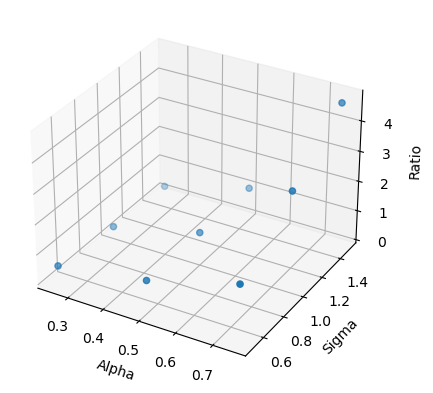

In [2]:
# Just want graphs and less clutter in terms of output
import warnings
warnings.filterwarnings("ignore")

# We define the parameters alpha and sigma
alpha_varying = [0.25, 0.5, 0.75]
sigma_varying = [0.5, 1, 1.5]

# We store the results that we get
alphastore = []
sigmastore = []
ratiostore = []

# We create a simple loop for all the different values that we want to examine
for alpha in alpha_varying:
    for sigma in sigma_varying:

        # We call our model specifications
        HHclass = HouseholdSpecializationModelClass()

     # We set the correct values for the parameters
        HHclass.par.alpha = alpha
        HHclass.par.sigma = sigma

        # We solve the model
        opt = HHclass.solve_discrete()

        # We start by defining our the ratio between HF and HM
        ratio = opt.HF / opt.HM

        # We store the results
        alphastore.append(alpha)
        sigmastore.append(sigma)
        ratiostore.append(ratio)

# Definings and plotting the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(alphastore, sigmastore, ratiostore)
ax.set_xlabel('Alpha')
ax.set_ylabel('Sigma')
ax.set_zlabel('Ratio')
plt.show()


In [3]:
def print_table():
    #We define an empty text string to enter a title later
    text = ''

    # Creating the top header of the table. Alpha is values downward and Sigma to the right.
    text += f'{"Alpha - Sigma":3s}'
    for j, sigma in enumerate(sigma_varying):
       HHclass.par.sigma = sigma
       text += f'{sigma:8.2f}' 
    text += '\n' + "-"*40 + "\n" # creating a line shift 
    
    # Creating the body of the table
    for i, alpha in enumerate(alpha_varying):
        HHclass.par.alpha = alpha
        if i > 0:
            text += '\n' # creating a line shift
        text += f'{alpha:8.2f}    |' # creating the left header
        for j, sigma in enumerate(sigma_varying):
            HHclass.par.sigma=sigma
            opt = HHclass.solve_discrete()
            text += f'{opt.HF/opt.HM:7.2f}'
    
    # Printing table to illustrate the output 
    print(text)

print_table()

Alpha - Sigma    0.50    1.00    1.50
----------------------------------------
    0.25    |   0.55   0.31   0.21
    0.50    |   1.00   1.00   1.00
    0.75    |   1.83   3.25   4.67


# Question 2

Explain your code and procedure

[0.22314355131420976, 0.0, 0.0, -0.11778303565638351, -0.2231435513142097]


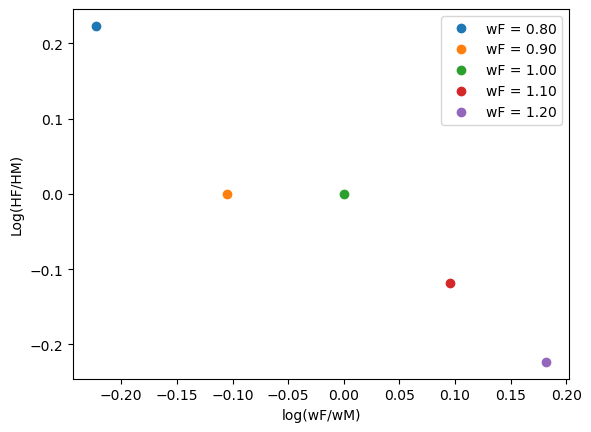

In [4]:
# Calling our class
HHclass = HouseholdSpecializationModelClass()

# We define our vector wF
wF_varying = [0.8, 0.9, 1, 1.1, 1.2]

#Store the wF values
wFstore = []

#Creating a loop for the different values
for wF in wF_varying:
    HHclass.par.wF = wF

    # Solve
    opt2 = HHclass.solve_discrete()

    # Define the log function
    logratio = np.log(opt2.HF/opt2.HM)

    # Plotting
    plt.plot(np.log(wF/HHclass.par.wM), logratio, 'o', label=f'wF = {wF/HHclass.par.wM:.2f}')

    # Storing results
    wFstore.append(logratio)

# Customizing plot 
plt.xlabel('log(wF/wM)')
plt.ylabel('Log(HF/HM)')
plt.legend()

# Printing
print(wFstore)
plt.show()


# Question 3

Explain your code and procedure

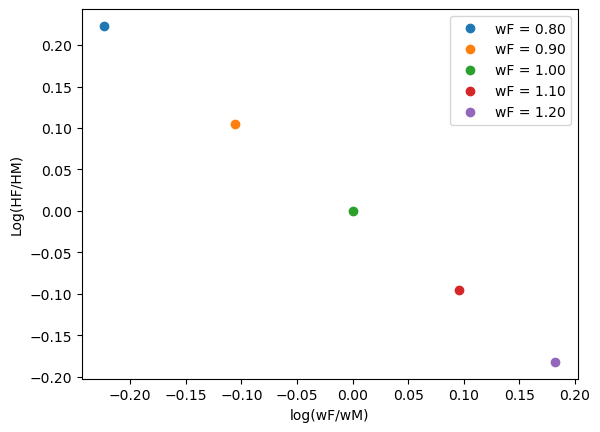

In [5]:
# Using the model to calculate optimal HF and HM
HHclass = HouseholdSpecializationModelClass()

# Looping over wF values
for wF in wF_varying:
    
    # Setting value 
    HHclass.par.wF = wF

    # Solving for discrete optimal choice
    sol = HHclass.solve_continuous()

    # Creating Ratio 
    ratio = sol.HF/sol.HM

    # Plotting 
    plt.plot(np.log(wF/HHclass.par.wM), np.log(ratio), 'o', label=f'wF = {wF/HHclass.par.wM:.2f}')

# Customizing plot 
plt.xlabel('log(wF/wM)')
plt.ylabel('Log(HF/HM)')
plt.legend()

# Printing
plt.show()

# Question 4

In [6]:
HHclass = HouseholdSpecializationModelClass()
result = HHclass.estimate()
print(f'The squared error is minimized when:')
print(f' - alpha = {HHclass.par.alpha:.3f}')
print(f' - sigma = {HHclass.par.sigma:.3f}')
print()
print(f'At these values, our coefficients are:')
print(f' - beta_hat0 = {HHclass.sol.beta0:.3f}')
print(f' - beta_hat1 = {HHclass.sol.beta1:.3f}')
print()
print(f'The target values:')
print(f' - beta0 = {HHclass.par.beta0_target:.3f}')
print(f' - beta1 = {HHclass.par.beta1_target:.3f}')
print()

print('Therefore, the error must be 0:')
print(f'The minimized squared error is: {result.fun:.8f}')



The squared error is minimized when:
 - alpha = 0.982
 - sigma = 0.100

At these values, our coefficients are:
 - beta_hat0 = 0.400
 - beta_hat1 = -0.100

The target values:
 - beta0 = 0.400
 - beta1 = -0.100

Therefore, the error must be 0:
The minimized squared error is: 0.00000000


ADD CONCISE CONLUSION.